In [133]:
import glob
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import simplekml
import contextily as ctx
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Helvetica'


In [59]:
def gdf_to_kml(gdf, filename):
    """
    Save a GeoDataFrame to a KML file.
    
    Parameters:
    - gdf: GeoDataFrame containing geometries.
    - filename: Output KML file name (e.g., 'output.kml').
    """
    # Ensure the GeoDataFrame is in EPSG:4326 (WGS84)
    if gdf.crs is None or gdf.crs.to_string() != "EPSG:4326":
        gdf = gdf.to_crs(epsg=4326)
    
    kml = simplekml.Kml()
    
    for idx, row in gdf.iterrows():
        geom = row.geometry
        # Use a 'name' column if available, otherwise use the index.
        name = str(row.get('name', idx))
        
        # Check if the geometry is a multi-geometry
        if hasattr(geom, 'geoms'):
            for subgeom in geom.geoms:
                _add_geometry_to_kml(kml, subgeom, name)
        else:
            _add_geometry_to_kml(kml, geom, name)
    
    # Save the KML file
    kml.save(filename)

def _add_geometry_to_kml(kml, geom, name):
    """
    Add a single geometry to the KML object.
    """
    if geom.geom_type == 'Point':
        kml.newpoint(name=name, coords=[(geom.x, geom.y)])
    elif geom.geom_type == 'LineString':
        kml.newlinestring(name=name, coords=list(geom.coords))
    elif geom.geom_type == 'Polygon':
        # Create a polygon using the exterior ring
        outer_coords = list(geom.exterior.coords)
        pol = kml.newpolygon(name=name, outerboundaryis=outer_coords)
        # Add inner boundaries (holes) if they exist
        if geom.interiors:
            pol.innerboundaryis = [list(interior.coords) for interior in geom.interiors]
    else:
        print(f"Geometry type '{geom.geom_type}' is not supported.")




In [36]:
data_dir = "/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857"

layers_dir = os.path.join(data_dir, "layers")
plants_dir = os.path.join(data_dir, "plants")
transmission_dir = os.path.join(data_dir, "transmission")

kml_layers_dir = os.path.join(layers_dir, "clipped_kml")
shp_layers_dir = os.path.join(layers_dir, "clipped_shp")

gas_shapefile = os.path.join(plants_dir, "gas_plant_clipped_shp", "gas_plants_clipped.shp")

transmission_shp = os.path.join(transmission_dir, "transmission_clipped", "transmission_clipped.shp")

output_bounding_box_kml = os.path.join(data_dir, "focal_area.kml")
output_transmission_kml = os.path.join(transmission_dir, "transmission_clipped.kml")
output_images_dir = os.path.join(data_dir, "images")


### Genrerate bounding box focal area KML file

```
EPSG:3857 BOX:
xmin = -12360927.926795248 
xmax = -12121322.029929128 
ymin = 5012380.2622691505 
ymax = 5168008.529693829
```


In [7]:
# Define the bounding box in EPSG:3857 (minx, miny, maxx, maxy)
# Replace these example values with your actual coordinates.
minx = -12360927.926795248
miny = 5012380.2622691505
maxx = -12121322.029929128 
maxy = 5168008.529693829

# Create a transformer object from EPSG:3857 to EPSG:4326.
# The always_xy=True flag ensures that the coordinate order is (x, y).
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Transform each corner of the bounding box:
# Lower left
ll_lon, ll_lat = transformer.transform(minx, miny)
# Lower right
lr_lon, lr_lat = transformer.transform(maxx, miny)
# Upper right
ur_lon, ur_lat = transformer.transform(maxx, maxy)
# Upper left
ul_lon, ul_lat = transformer.transform(minx, maxy)

# Create a KML file and add a polygon representing the bounding box.
kml = simplekml.Kml()
# Define the polygon coordinates (note that KML requires coordinates in (lon, lat))
polygon_coords = [
    (ll_lon, ll_lat),
    (lr_lon, lr_lat),
    (ur_lon, ur_lat),
    (ul_lon, ul_lat),
    (ll_lon, ll_lat)  # close the polygon
]
polygon = kml.newpolygon(name="Bounding Box", outerboundaryis=polygon_coords)
polygon.style.polystyle.fill = 1  # Enable fill
polygon.style.polystyle.outline = 1  # Enable outline

# Set the polygon color (red with transparency)
polygon.style.polystyle.color = simplekml.Color.changealphaint(100, simplekml.Color.red)

# Save the KML file
kml.save(output_bounding_box_kml)


### Process yearly power plant file

In [12]:
gdf = gpd.read_file(gas_shapefile)


In [18]:
for yr in gdf.sited_year.unique():
    
    x = gdf.loc[gdf["sited_year"] == yr].copy()

    output_kml = os.path.join(plants_dir, f"{yr}_gas_plants_clipped.kml")

    gdf_to_kml(x, output_kml)


### Convert transmission lines shapefile to a styled KML file

In [22]:
gdf = gpd.read_file(transmission_shp)


In [27]:
gdf_to_kml(gdf[["FID", "geometry"]], output_transmission_kml)


### Plotting workflow

In [54]:
# Enable Fiona KML driver
# Necessary for GeoPandas versions that don't enable it by default
try:
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    # For older geopandas/fiona versions, it might be LIBKML
    gpd.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
except Exception as e:
    warnings.warn(f"Could not explicitly enable KML driver, relying on default Fiona support. Error: {e}")


In [132]:
# specify the order of display
custom_order_of_display = [
    "flood_risk_clipped.kml",
    "slope_clipped.kml",
    "airport_clipped.kml",
    "cooling_water_clipped.kml",
    "protected_areas_clipped.kml",
    "2030_gas_plants_clipped.kml",
    "2035_gas_plants_clipped.kml",
    "2040_gas_plants_clipped.kml",
    "2045_gas_plants_clipped.kml",
    "2050_gas_plants_clipped.kml",
]

exclusion_kmls = glob.glob(os.path.join(kml_layers_dir, "*.kml"))
plants_kmls = glob.glob(os.path.join(plants_dir, "*.kml"))

temp_kmls = exclusion_kmls + plants_kmls

# reorder
combined_kmls = []
for i in custom_order_of_display:
    for x in temp_kmls:
        if i in x:
            combined_kmls.append(Path(x))

combined_kmls


[PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/layers/clipped_kml/flood_risk_clipped.kml'),
 PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/layers/clipped_kml/slope_clipped.kml'),
 PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/layers/clipped_kml/airport_clipped.kml'),
 PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/layers/clipped_kml/cooling_water_clipped.kml'),
 PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/layers/clipped_kml/protected_areas_clipped.kml'),
 PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/plants/2030_gas_plants_clipped.kml'),
 PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/plants/2040_gas_plants_clipped.kml'),
 PosixPath('/Users/d3y010/repos/github/power_plant_visualization/data/data_epsg3857/plants/2045_gas_plants_clip

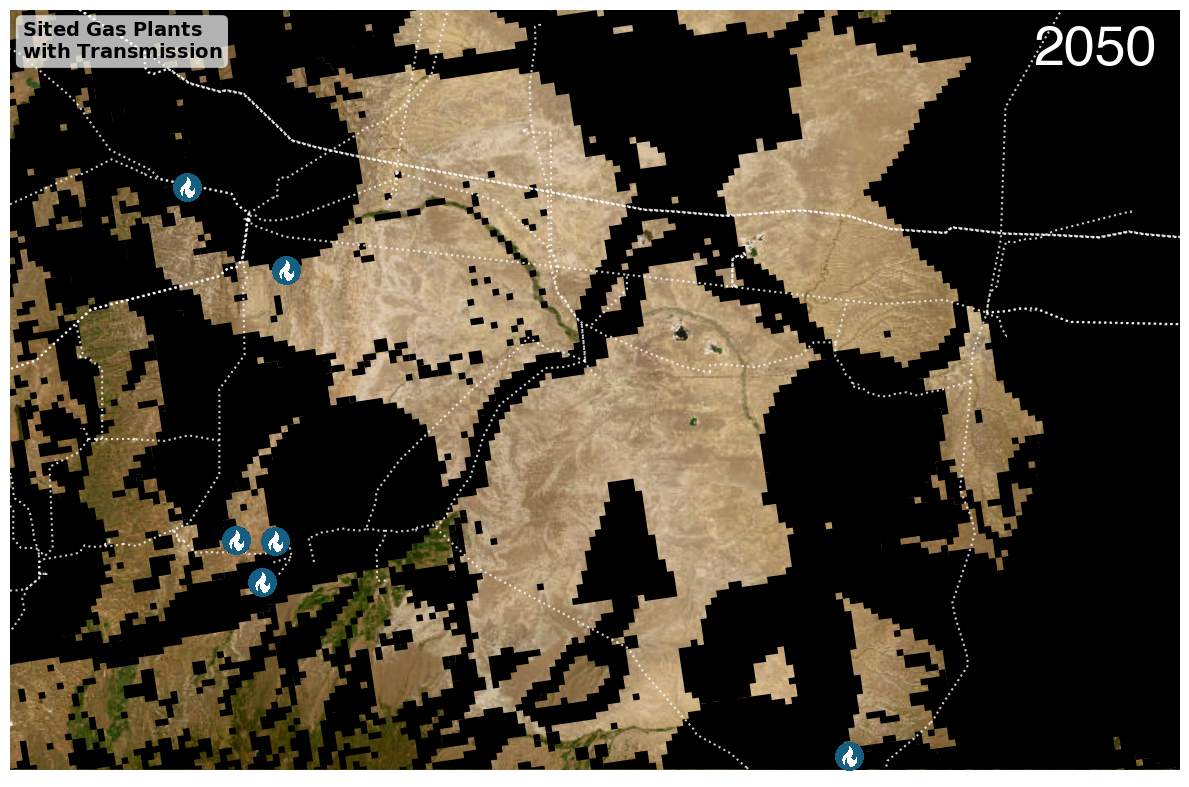

In [153]:
# custom order to legend display
legend_dict = {
    "flood_risk_clipped.kml": "Flood Risk",
    "slope_clipped.kml": "Slope Exceedance",
    "airport_clipped.kml": "Airport Vicinity",
    "cooling_water_clipped.kml": "Available Water",
    "protected_areas_clipped.kml": "Protected Area",
    "2030_gas_plants_clipped.kml": None,
    "2035_gas_plants_clipped.kml": None,
    "2040_gas_plants_clipped.kml": None,
    "2045_gas_plants_clipped.kml": None,
    "2050_gas_plants_clipped.kml": None,
}

# content to appear in the legend
standard_header = r"$\bf{Unsuitable\ Gas\ Plant\ Areas}$"
altered_header = r"$\bf{Sited\ Gas\ Plants}$"
transmission_header = r"$\bf{Sited\ Gas\ Plants}$" + "\n" + r"$\bf{with\ Transmission}$"

# Configuration
TARGET_CRS = 'EPSG:3857'  # Web Mercator, suitable for most web basemaps
SAVE_DPI = 150

# Plot Customization
EXCLUSION_COLOR = 'black'
EXCLUSION_ALPHA = 1.0   # Transparency
EXCLUSION_EDGECOLOR = None  # 'darkred'
BUFFER_PERCENT = 0.00   # Add buffer around ROI for map extent

# Power plant customization
marker_zoom_level = 0.011
marker_file = os.path.join(data_dir, "round_gas_icon.png")

try:
    roi_gdf = gpd.read_file(output_bounding_box_kml)
    if roi_gdf.crs is None:
        print("Warning: ROI KML has no CRS defined. Assuming EPSG:4326 (WGS 84).")
        roi_gdf.crs = 'EPSG:4326'
except Exception as e:
    raise FileNotFoundError(f"Error loading ROI KML: {e}")

# Reproject ROI to target CRS for setting extent
roi_proj_gdf = roi_gdf.to_crs(TARGET_CRS)

# --- Create Plot (once) ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# --- Set Map Extent based on ROI (BEFORE loop) ---
minx, miny, maxx, maxy = roi_proj_gdf.total_bounds
x_buffer = (maxx - minx) * BUFFER_PERCENT
y_buffer = (maxy - miny) * BUFFER_PERCENT
ax.set_xlim(minx - x_buffer, maxx + x_buffer)
ax.set_ylim(miny - y_buffer, maxy + y_buffer)

# Add Satellite Basemap (after plotting all exclusion zones)
try:
    ctx.add_basemap(
        ax,
        source=ctx.providers.Esri.WorldImagery,
        crs=roi_proj_gdf.crs.to_string(),
        attribution="",
    )
except Exception as e:
    print(f"Error adding basemap: {e}. Check internet connection and contextily installation.")

# --- Final Touches (Axis off, Title, and Text Box) ---
# ax.set_title('Cumulative Exclusion Zones within ROI')
ax.set_axis_off()
plt.tight_layout()

# Load custom marker image for plants (if needed later)
custom_marker_img = mpimg.imread(marker_file)

def add_custom_marker(ax, x, y, img, zoom):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

# Assuming plants_kmls is a list of file paths for plant layers.
plants_file_basenames = [os.path.basename(f) for f in plants_kmls]

# save baselayer before other layers are added
text_content = standard_header
legend_box = ax.text(
    0.01, 0.985,              # Position in Axes coordinates (x=0.02, y=0.98)
    text_content,          # Text content
    transform=ax.transAxes,   # Coordinates relative to the Axes
    fontsize=14,
    color='black',
    va='top',
    ha='left',
    fontname='Helvetica',     # Ensures non-math text uses Helvetica
    bbox=dict(
        boxstyle='round',     # Rounded edges
        facecolor='white',    # White background
        alpha=0.7,            # opacity
        edgecolor='none'      # No border; set a color if you prefer one
    )
)

roi_proj_gdf.plot(ax=ax, color="white", alpha=0.0)                                 
output_path = Path(output_images_dir) / "basemap_roi.jpg"
fig.savefig(output_path, dpi=SAVE_DPI, bbox_inches='tight', facecolor='white')
text_content += "\n\n"
year_text_box = ax.text(0.98, 0.98, "", va='top', ha='right')

# --- Iteratively Load, Plot, and SAVE Exclusion Zones ---
for i, kml_file in enumerate(combined_kmls):

    try:
        # Load current exclusion zone KML
        exclusion_gdf = gpd.read_file(kml_file)

        # Check and set CRS if missing (assume WGS84 for KML)
        if exclusion_gdf.crs is None:
            print(f"  Warning: CRS missing for {kml_file.name}. Assuming EPSG:4326.")
            exclusion_gdf.crs = 'EPSG:4326'

        # Reproject to target CRS for plotting
        exclusion_proj_gdf = exclusion_gdf.to_crs(TARGET_CRS)

        # Plot the current layer:
        if kml_file.name in plants_file_basenames:
            
            # For plant layers, overlay custom markers for each point geometry.
            for idx, row in exclusion_proj_gdf.iterrows():
                geom = row.geometry
                if geom.geom_type == 'Point':
                    x, y = geom.x, geom.y
                    add_custom_marker(ax, x, y, custom_marker_img, zoom=marker_zoom_level)
                else:
                    # For non-point geometries, fall back to normal plotting.
                    exclusion_proj_gdf.plot(
                        ax=ax,
                        color=EXCLUSION_COLOR,
                        alpha=EXCLUSION_ALPHA,
                        edgecolor=EXCLUSION_EDGECOLOR
                    )
        else:
            exclusion_proj_gdf.plot(
                ax=ax,
                color=EXCLUSION_COLOR,
                alpha=EXCLUSION_ALPHA,
                edgecolor=EXCLUSION_EDGECOLOR
            )

        if kml_file.name in plants_file_basenames:
            text_content = altered_header

            year_text_box.remove()
            year_text_box = ax.text(
                0.98, 0.98,
                kml_file.name.split("_")[0],
                transform=ax.transAxes,  
                fontsize=40,
                color='white',
                va='top',
                ha='right',
                fontname='Helvetica', 
            )
            
        else:
            text_content += legend_dict[kml_file.name] + "\n"

        # remove existing legend box
        legend_box.remove()

        # build new box
        legend_box = ax.text(
            0.01, 0.985,               # Position in Axes coordinates (x=0.02, y=0.98)
            text_content,             # Text content
            transform=ax.transAxes,   # Coordinates relative to the Axes
            fontsize=14,
            color='black',
            va='top',
            ha='left',
            fontname='Helvetica',     # Ensures non-math text uses Helvetica
            bbox=dict(
                boxstyle='round',     # Rounded edges
                facecolor='white',    # White background
                alpha=0.7,            # opacity
                edgecolor='none'      # No border; set a color if you prefer one
            )
        )

        # --- Save the Plot AFTER adding the current layer ---
        step_filename = f"{os.path.basename(kml_file)}.jpg"
        output_path = Path(output_images_dir) / step_filename

        try:
            fig.savefig(output_path, dpi=SAVE_DPI, bbox_inches='tight', facecolor='white')
        except Exception as e:
            print(f"  Error saving plot for step {i+1}: {e}")

    except Exception as e:
        print(f"  Error processing {kml_file.name}: {e}. Skipping this file.")

# save baselayer before other layers are added
legend_box.remove()
text_content = transmission_header
legend_box = ax.text(
    0.01, 0.985,              # Position in Axes coordinates (x=0.02, y=0.98)
    text_content,          # Text content
    transform=ax.transAxes,   # Coordinates relative to the Axes
    fontsize=14,
    color='black',
    va='top',
    ha='left',
    fontname='Helvetica',     # Ensures non-math text uses Helvetica
    bbox=dict(
        boxstyle='round',     # Rounded edges
        facecolor='white',    # White background
        alpha=0.7,            # opacity
        edgecolor='none'      # No border; set a color if you prefer one
    )
)

transmission_gdf = gpd.read_file(transmission_shp).to_crs(TARGET_CRS)
transmission_gdf.plot(ax=ax, color="white", alpha=0.8, linestyle=":")                                 
output_path = Path(output_images_dir) / "transmission.jpg"
fig.savefig(output_path, dpi=SAVE_DPI, bbox_inches='tight', facecolor='white')


